# TensorFlow 2.x
## 引入依赖

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers
import numpy as np

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2022-11-15 15:42:59.337759: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Num GPUs Available:  2


2022-11-15 15:43:00.780064: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-15 15:43:00.781758: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-11-15 15:43:00.794359: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6325GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-11-15 15:43:00.795529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:82:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6325GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-11-15 15:43:00.795559: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
202

# 定义参数

In [2]:
# Training parameters.
learning_rate = 0.01
training_steps = 2000
batch_size = 256
display_step = 100

# 数据集

In [3]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255., x_test / 255.
x_train = x_train[..., tf.newaxis].astype("float32")
x_test = x_test[..., tf.newaxis].astype("float32")

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


2022-11-15 15:43:17.715540: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-15 15:43:17.979448: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6325GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-11-15 15:43:17.983652: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:82:00.0 name: GeForce GTX 1080 Ti computeCapability: 6.1
coreClock: 1.6325GHz coreCount: 28 deviceMemorySize: 10.92GiB deviceMemoryBandwidth: 451.17GiB/s
2022-11-15 15:43:17.983707: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-11-15 15:43:17.983761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


# 模型定义

In [4]:
from tensorflow.keras import Model, layers
class SimpleConvNet(Model):
    def __init__(self):
        super(SimpleConvNet, self).__init__()
        self.conv1 = layers.Conv2D(32, 3, activation='relu')
        self.flatten = layers.Flatten()
        self.d1 = layers.Dense(128, activation='relu')
        self.d2 = layers.Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)

neural_net = SimpleConvNet()

# 训练和验证
## 损失函数、优化器、指标

In [5]:
# Cross-Entropy Loss.
# Note that this will apply 'softmax' to the logits.
criterion = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')


## 训练/验证 单步函数

In [6]:

def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = neural_net(images, training=True)
    loss = criterion(labels, predictions)
  gradients = tape.gradient(loss, neural_net.trainable_variables)
  optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))
  train_loss(loss)
  train_accuracy(labels, predictions)


def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = neural_net(images, training=False)
  t_loss = criterion(labels, predictions)
  test_loss(t_loss)
  test_accuracy(labels, predictions)

## 开始训练验证

In [7]:
EPOCHS = 5

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_dataset:
    train_step(images, labels)

  for test_images, test_labels in test_dataset:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

2022-11-15 15:43:55.335438: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-11-15 15:43:56.441070: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2022-11-15 15:43:56.551832: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2022-11-15 15:43:57.973112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-11-15 15:43:58.392924: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


Epoch 1, Loss: 0.19633664190769196, Accuracy: 94.30500030517578, Test Loss: 0.07110926508903503, Test Accuracy: 97.7699966430664
Epoch 2, Loss: 0.04434787854552269, Accuracy: 98.5999984741211, Test Loss: 0.06300213187932968, Test Accuracy: 98.08999633789062
Epoch 3, Loss: 0.024702735245227814, Accuracy: 99.19000244140625, Test Loss: 0.059077899903059006, Test Accuracy: 98.08999633789062
Epoch 4, Loss: 0.015444943681359291, Accuracy: 99.49166870117188, Test Loss: 0.08031914383172989, Test Accuracy: 97.91999816894531
Epoch 5, Loss: 0.012424680404365063, Accuracy: 99.58499908447266, Test Loss: 0.08927407115697861, Test Accuracy: 97.94999694824219


## 预测

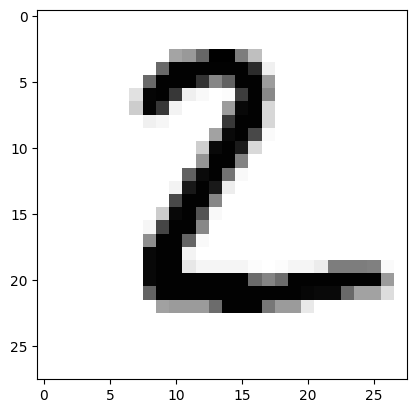

In [8]:
import matplotlib.pyplot as plt
plt.imshow(x_test[1].reshape(28, 28), cmap='Greys')

In [9]:
predictions = neural_net(x_test[1].reshape(1, 28, 28, 1), training=False)
np.argmax(predictions)

2